# Threshold Sensitivity Analysis

This notebook analyzes the effect of the reasoning threshold on the model's performance on the validation set (GSM8K-Val).

It reads the pre-computed results from `leaderboard_thinkbrake.json` and compares them against the **Rollout (Baseline)** results from `leaderboard_rollout.json`.

In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plot style
sns.set_theme(style="whitegrid")

# Constants
OUTPUT_DIR = Path("../outputs")
THINKBRAKE_FILE = OUTPUT_DIR / "leaderboard_thinkbrake.json"
ROLLOUT_FILE = OUTPUT_DIR / "leaderboard_rollout.json"

MODEL_NAME = "Qwen/Qwen3-4B-Thinking-2507"
CATEGORY = "gsm8k-val"

In [ ]:
def load_leaderboard(file_path):
    if not file_path.exists():
        print(f"Warning: {file_path} not found.")
        return {}
    with open(file_path, "r", encoding="utf-8") as f:
        return json.load(f)


thinkbrake_data = load_leaderboard(THINKBRAKE_FILE)
rollout_data = load_leaderboard(ROLLOUT_FILE)


# Helper to find model data handling potnetial name variations (slash vs underscore)
def get_model_data(data, model_name):
    if model_name in data:
        return data[model_name]

    # Try underscore replacement
    alt_name = model_name.replace("/", "_")
    if alt_name in data:
        return data[alt_name]

    print(f"Model {model_name} (or {alt_name}) not found in data.")
    return None


tb_model_data = get_model_data(thinkbrake_data, MODEL_NAME)
ro_model_data = get_model_data(rollout_data, MODEL_NAME)

print(f"Loaded data for: {MODEL_NAME}")
if tb_model_data and CATEGORY in tb_model_data:
    print(f"Found ThinkBrake results for {CATEGORY}")
else:
    print(f"No ThinkBrake results for {CATEGORY}")

if ro_model_data and CATEGORY in ro_model_data:
    print(f"Found Rollout results for {CATEGORY}")
else:
    print(f"No Rollout results for {CATEGORY}")

import math
import re
from collections import defaultdict


def calculate_pass_at_k(n, c, k):
    if n < k:
        return 1.0 if c > 0 else 0.0
    if c == n:
        return 1.0
    try:
        prob_fail = math.comb(n - c, k) / math.comb(n, k)
        return 1.0 - prob_fail
    except Exception:
        return 0.0


def extract_answer(text):
    if not isinstance(text, str):
        return ""
    # Look for \boxed{...}
    matches = re.findall(r"\\boxed\{(.*?)\}", text)
    if matches:
        return matches[-1]
    return ""


def verify_answer(pred, gt):
    def clean(s):
        s = str(s).replace(",", "").strip()
        try:
            return float(s)
        except:
            return s

    return clean(pred) == clean(gt)

Loaded data for: Qwen/Qwen3-4B-Thinking-2507
Found ThinkBrake results for gsm8k-val
Found Rollout results for gsm8k-val


In [3]:
plot_data = []

rollout_baseline = None
if ro_model_data and CATEGORY in ro_model_data:
    rollout_baseline = ro_model_data[CATEGORY]

# Process ThinkBrake Data
if tb_model_data and CATEGORY in tb_model_data:
    cat_data = tb_model_data[CATEGORY]
    for key, stats in cat_data.items():
        if key.startswith("threshold_"):
            try:
                t_val = float(key.replace("threshold_", ""))

                # Calculate Token Reduction vs Rollout Baseline if available
                token_reduction = None
                if rollout_baseline:
                    base_tokens = rollout_baseline.get("avg_token_length", 0)
                    curr_tokens = stats["avg_token_length"]
                    if base_tokens > 0:
                        token_reduction = (
                            (base_tokens - curr_tokens) / base_tokens * 100
                        )

                entry = {
                    "threshold": t_val,
                    "accuracy": stats["accuracy"],
                    "majority_accuracy": stats.get("majority_accuracy"),
                    "avg_token_length": stats["avg_token_length"],
                    "token_reduction": token_reduction,
                    "type": "ThinkBrake",
                }
                if "pass@k" in stats:
                    for k, v in stats["pass@k"].items():
                        entry[f"pass@{k}"] = v

                plot_data.append(entry)
            except ValueError:
                continue

df = pd.DataFrame(plot_data)
if not df.empty:
    df = df.sort_values("threshold")
    print(df.head())
else:
    print("No data available for plotting.")

   threshold  accuracy  majority_accuracy  avg_token_length  token_reduction  \
0       0.05      94.4               95.5          1199.747        17.903924   
1       0.10      94.2               94.0          1213.120        16.988839   
2       0.25      94.8               95.5          1185.237        18.896812   
3       1.00      94.3               94.5          1169.802        19.952995   
4       2.50      94.0               94.0          1111.010        23.976004   

         type  pass@1  pass@2  pass@4  pass@5  
0  ThinkBrake    94.4   95.50    95.9    96.0  
1  ThinkBrake    94.2   95.10    96.1    96.5  
2  ThinkBrake    94.8   95.70    96.0    96.0  
3  ThinkBrake    94.3   95.05    95.7    96.0  
4  ThinkBrake    94.0   94.80    95.4    95.5  


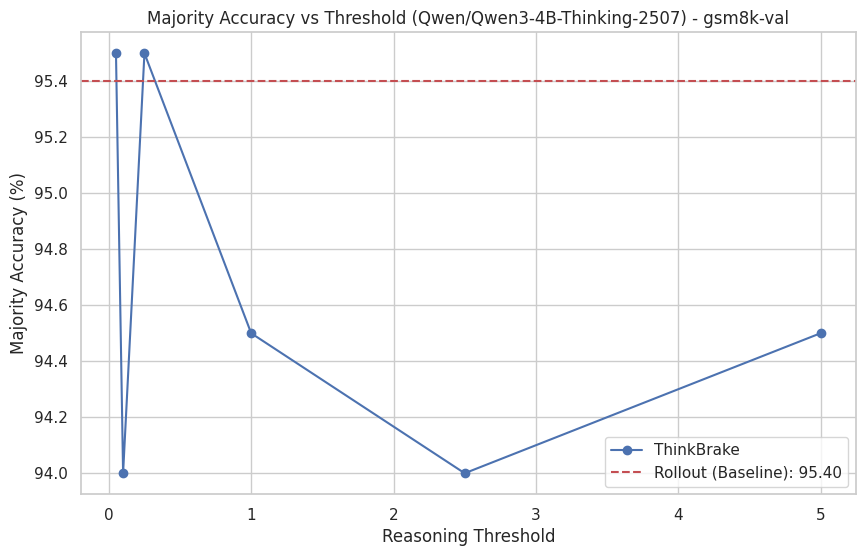

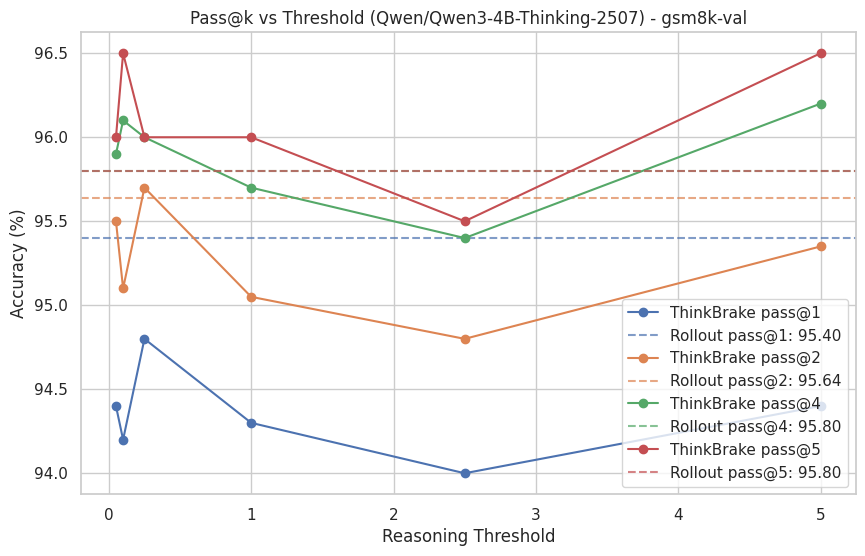

In [ ]:
def plot_metric(df, metric, title, ylabel, baseline_stats=None, baseline_key=None):
    if df.empty or metric not in df.columns:
        print(f"No data to plot for {metric}.")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(df["threshold"], df[metric], marker="o", label="ThinkBrake")

    if baseline_stats and baseline_key:
        val = baseline_stats.get(baseline_key)
        if val is not None:
            plt.axhline(
                y=val,
                color="r",
                linestyle="--",
                label=f"Rollout (Baseline): {val:.2f}",
            )

    plt.title(title)
    plt.xlabel("Reasoning Threshold")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_metric(
    df,
    "majority_accuracy",
    f"Majority Accuracy vs Threshold ({MODEL_NAME}) - {CATEGORY}",
    "Majority Accuracy (%)",
    rollout_baseline,
    "majority_accuracy",
)

# Plot Pass@k
pass_k_cols = [c for c in df.columns if c.startswith("pass@")]
pass_k_cols.sort(key=lambda x: int(x.split("@")[1]))

if pass_k_cols:
    plt.figure(figsize=(10, 6))
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    for i, col in enumerate(pass_k_cols):
        color = colors[i % len(colors)]
        plt.plot(
            df["threshold"], df[col], marker="o", color=color, label=f"ThinkBrake {col}"
        )

        # Add Baseline for this k if available
        k_val = col.split("@")[1]
        if rollout_baseline and "pass@k" in rollout_baseline:
            pk_base = rollout_baseline["pass@k"]
            val = pk_base.get(k_val) or pk_base.get(int(k_val))
            if val is not None:
                plt.axhline(
                    y=val,
                    color=color,
                    linestyle="--",
                    alpha=0.7,
                    label=f"Rollout {col}: {val:.2f}",
                )

    plt.title(f"Pass@k vs Threshold ({MODEL_NAME}) - {CATEGORY}")
    plt.xlabel("Reasoning Threshold")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()


# --- Performance vs Token Cost Analysis ---
def plot_tradeoff(df, metrics_dict, title):
    if df.empty:
        return

    plt.figure(figsize=(12, 8))

    available_metrics = []
    for metric, label in metrics_dict.items():
        if metric in df.columns:
            plt.plot(df["avg_token_length"], df[metric], marker="o", label=label)
            available_metrics.append(metric)

            for idx, row in df.iterrows():
                plt.annotate(
                    f"t={row['threshold']}",
                    (row["avg_token_length"], row[metric]),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha="center",
                    fontsize=8,
                )

    if not available_metrics:
        return

    # Add Rollout Baseline point (Accuracy)
    if rollout_baseline:
        base_tokens = rollout_baseline.get("avg_token_length", 0)
        base_acc = rollout_baseline.get("accuracy", 0)
        if base_tokens > 0:
            plt.scatter(
                [base_tokens],
                [base_acc],
                color="r",
                s=100,
                marker="*",
                label="Rollout Baseline (Acc)",
            )
            plt.annotate(
                "Baseline",
                (base_tokens, base_acc),
                xytext=(0, -15),
                textcoords="offset points",
                ha="center",
                color="r",
            )

    plt.title(title)
    plt.xlabel("Average Token Length (Compute Cost)")
    plt.ylabel("Performance (%)")
    plt.legend()
    plt.grid(True)
    plt.show()


tradeoff_metrics = {"accuracy": "Accuracy", "majority_accuracy": "Majority Accuracy"}
for col in pass_k_cols:
    tradeoff_metrics[col] = f"{col}"

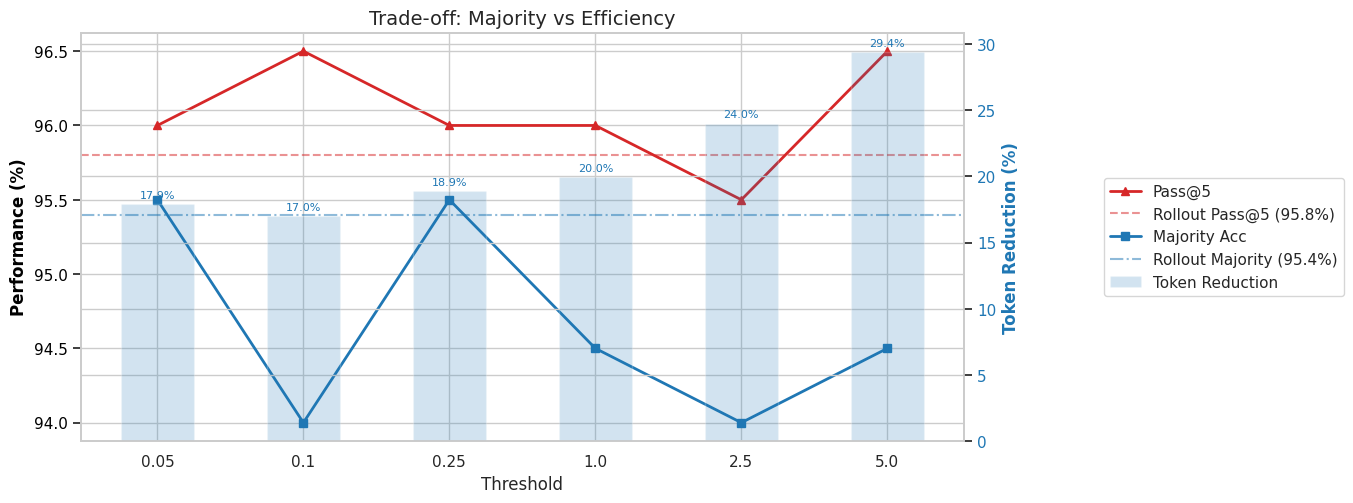

In [ ]:
def plot_advanced_comparison(df, baseline_stats):
    if df.empty:
        return

    has_pass5 = "pass@5" in df.columns
    has_majority = "majority_accuracy" in df.columns

    if not (has_pass5 or has_majority):
        print("Neither pass@5 nor majority_accuracy available for advanced comparison.")
        return

    df_sorted = df.sort_values("threshold")
    thresholds_str = df_sorted["threshold"].astype(str)

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Metric colors
    color_p5 = "tab:red"
    color_maj = "tab:blue"

    ax1.set_xlabel("Threshold")
    ax1.set_ylabel("Performance (%)", color="black", fontweight="bold")

    lines = []

    if has_pass5:
        (l1,) = ax1.plot(
            thresholds_str,
            df_sorted["pass@5"],
            color=color_p5,
            marker="^",
            linewidth=2,
            label="Pass@5",
        )
        lines.append(l1)
        # Baseline Pass@5
        if baseline_stats and "pass@k" in baseline_stats:
            p5_base = baseline_stats["pass@k"].get("5") or baseline_stats["pass@k"].get(
                5
            )
            if p5_base:
                l1b = ax1.axhline(
                    y=p5_base,
                    color=color_p5,
                    linestyle="--",
                    alpha=0.5,
                    label=f"Rollout Pass@5 ({p5_base:.1f}%)",
                )
                lines.append(l1b)

    if has_majority:
        (l2,) = ax1.plot(
            thresholds_str,
            df_sorted["majority_accuracy"],
            color=color_maj,
            marker="s",
            linewidth=2,
            label="Majority Acc",
        )
        lines.append(l2)
        maj_base = baseline_stats.get("majority_accuracy")
        if maj_base:
            l2b = ax1.axhline(
                y=maj_base,
                color=color_maj,
                linestyle="-.",
                alpha=0.5,
                label=f"Rollout Majority ({maj_base:.1f}%)",
            )
            lines.append(l2b)

    ax1.tick_params(axis="y", labelcolor="black")

    # Axis 2: Efficiency (Token Rduction)
    ax2 = ax1.twinx()
    color_eff = "tab:blue"

    if (
        "token_reduction" in df_sorted.columns
        and df_sorted["token_reduction"].notna().any()
    ):
        ax2.set_ylabel("Token Reduction (%)", color=color_eff, fontweight="bold")
        bars = ax2.bar(
            thresholds_str,
            df_sorted["token_reduction"],
            color=color_eff,
            alpha=0.2,
            width=0.5,
            label="Token Reduction",
        )
        ax2.tick_params(axis="y", labelcolor=color_eff)

        # Annotations on bars
        for bar in bars:
            height = bar.get_height()
            if height != 0:
                ax2.annotate(
                    f"{height:.1f}%",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center",
                    va="bottom",
                    color=color_eff,
                    fontsize=8,
                )
        lines.append(bars)
    else:
        ax2.set_ylabel("Avg Token Length", color=color_eff, fontweight="bold")
        (l3,) = ax2.plot(
            thresholds_str,
            df_sorted["avg_token_length"],
            color=color_eff,
            linestyle=":",
            marker="x",
            label="Avg Tokens",
        )
        ax2.tick_params(axis="y", labelcolor=color_eff)
        lines.append(l3)

    plt.title(
        f"Trade-off: Performance vs Efficiency",
        fontsize=14,
    )

    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="center left", bbox_to_anchor=(1.15, 0.5))

    plt.grid(True, axis="x", alpha=0.3)
    fig.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()


plot_advanced_comparison(df, rollout_baseline)

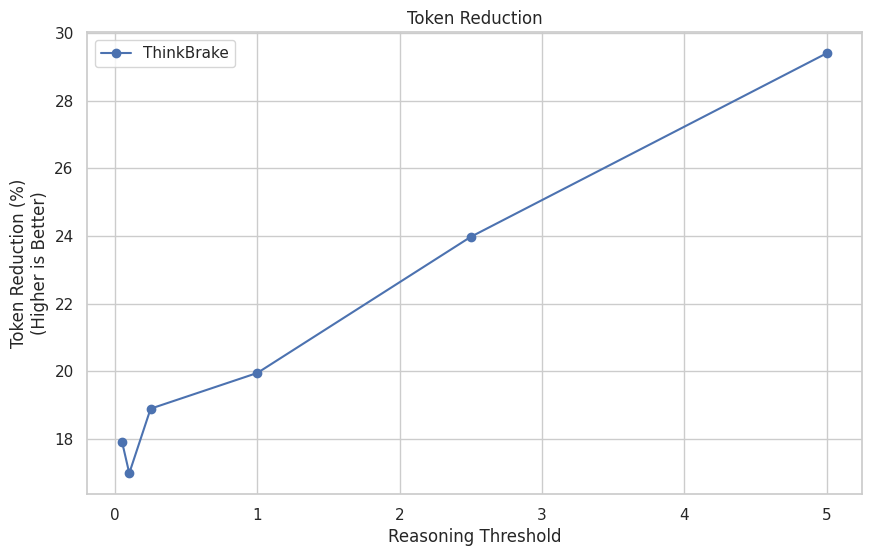

In [5]:
plot_metric(
    df,
    "token_reduction",
    f"Token Reduction",
    "Token Reduction (%)\n(Higher is Better)",
    None,
    None,
)